In [2]:
#importation
import pandas as pd
from fastai.vision.utils import get_image_files #allow to collect images from a repertory and to display it
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#importation of datasets
train = pd.read_csv('train.csv')


In [4]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
train.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
#collect of images

train_images_path = "train/train"
test_images_path = "test/test"

train_images = get_image_files(train_images_path)
test_images = get_image_files(test_images_path)

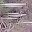

In [7]:
im = Image.open(train_images[0])
im

has_cactus
1    13136
0     4364
Name: count, dtype: int64


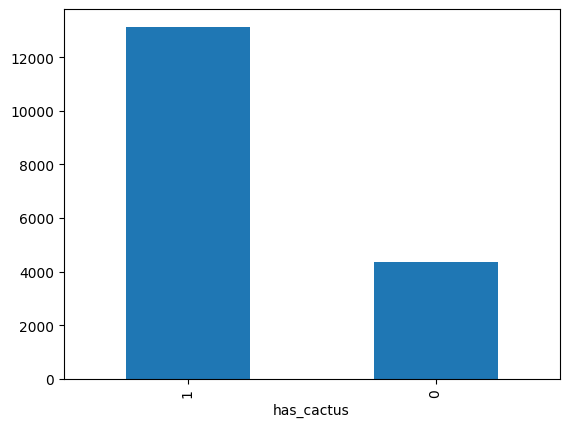

In [8]:
#data distribution
train['has_cactus'].value_counts().plot(kind='bar')
print(train['has_cactus'].value_counts())

#we need to balance the dataset...


In [9]:
##normlization of the images and take the name of the images

normalized_images = []
normalized_images_names = []
train_images = get_image_files('train/train')

for image_path in train_images:
    im = Image.open(image_path)
    im_array = np.array(im)
    im_array = im_array.astype('float32') / 255.0
    normalized_images.append(im_array)
    normalized_images_names.append(os.path.basename(image_path)) # add the name to the list in order to if there are cactus or no


In [10]:
print(normalized_images_names[0])

0004be2cfeaba1c0361d39e2b000257b.jpg


In [11]:
normalized_images[0].shape
#normalized_images[0][0]

(32, 32, 3)

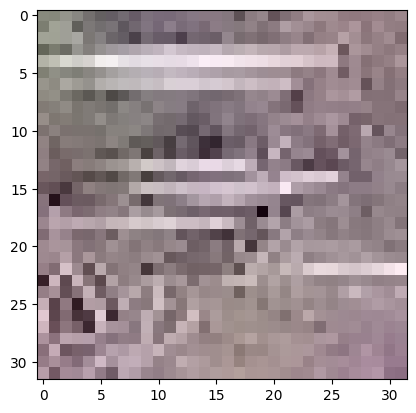

In [12]:
plt.show(plt.imshow(normalized_images[0]))

In [13]:
#separate images with cactus and without cactus

#Create a dictionary to map image names to their indice
name_to_index = {os.path.basename(image_path): idx for idx, image_path in enumerate(train_images)}
df_noCactus = [] #images without cactus
df_noCactus_name = [] #names of images without cactus

for index, row in train.iterrows():
    if row['has_cactus'] == 0:
        image_name = row['id']
        image_index = name_to_index[image_name] #use the dictionary to find the corresponding index


        df_noCactus_name.append(normalized_images_names[image_index])
        df_noCactus.append(normalized_images[image_index])

In [14]:
len(df_noCactus)

4364

In [15]:
##random oversampling

def add_noise(img,variance=0.1,mean=0):
    """add gaussian noise to an image"""
    noise = np.random.normal(mean, variance, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def rotation(img, angle=90):
    """rotate an image by a given angle in degrees"""
    return np.rot90(img, k=angle//90)

def luminosity(img, factor=1):
    """change the luminosity of an image"""
    return np.clip(img * factor, 0., 1.)




In [16]:
def modified_image(im):
    """apply random transformations to an image"""
    im = im.copy()
    if np.random.rand() < 0.5:
        im = rotation(im, angle=np.random.choice([90, 180, 270]))
    if np.random.rand() < 0.5:
        im = luminosity(im, factor=np.random.uniform(0.5, 1.5))
    if np.random.rand() < 0.5:
        im = add_noise(im, variance=np.random.uniform(0, 0.05))
    return im

In [17]:
###new images of no cactus
new_images = [] #new images of no cactus
number_of_image=train['has_cactus'].value_counts()[1]-train['has_cactus'].value_counts()[0]
for k in range(number_of_image):
    p = np.random.randint(0, len(df_noCactus))
    new_images.append(modified_image(df_noCactus[p]))

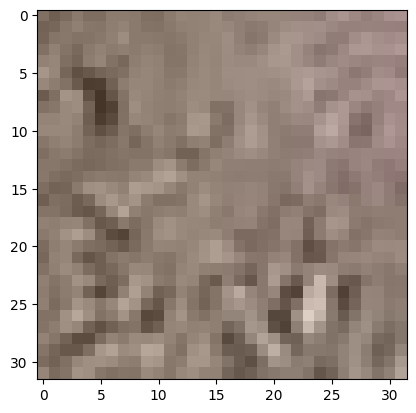

8772


In [18]:
plt.show(plt.imshow(new_images[9]))
print(len(new_images))

In [19]:
##create a new dataset with the new images
new_images_id=np.zeros(len(new_images))
new_images_has_cactus=np.zeros(len(new_images))

##concatenate the new images with the old images
new_images=np.array(new_images)
normalized_images=np.array(normalized_images)
df_Cactus=np.concatenate((normalized_images,new_images),axis=0)

new_images_name=np.array(new_images_id)
normalized_images_names=np.array(normalized_images_names)
df_Cactus_id=np.concatenate((normalized_images_names,new_images_name),axis=0)

has_cactus=train['has_cactus'].to_numpy()
new_images_has_cactus=np.concatenate((has_cactus,new_images_has_cactus),axis=0)

# flatten the images
#df_Cactus_list = [img.flatten().tolist() for img in df_Cactus]

#print the shape of the new dataset
print(df_Cactus.shape)



(26272, 32, 32, 3)


In [25]:
print("there are :",np.sum(new_images_has_cactus),"cactus and ",len(new_images_has_cactus)-np.sum(new_images_has_cactus),"no cactus")

there are : 13136.0 cactus and  13136.0 no cactus
